In [2]:
#Importação de bibliotecas

import pandas as pd
import numpy as np
import inflection
from scipy  import stats
import gdown
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics         import balanced_accuracy_score, precision_score, classification_report
from sklearn.metrics         import recall_score, f1_score, make_scorer, cohen_kappa_score
from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold

<h2>Carregando os dados</h2>

In [3]:

#Baixando o dataset do google drive
file_id = '1Wgxauwk6m5cIsP1ji9OQ1g1Z83h4BN5j'
url = f'https://drive.google.com/uc?id={file_id}'

gdown.download(url, 'dados.csv', quiet=False)

df1 = pd.read_csv('dados.csv')
#df1 = pd.read_csv('C:/Users/Dell/Downloads/PS_20174392719_1491204439457_log.csv')
df1.head(10)

Downloading...
From (original): https://drive.google.com/uc?id=1Wgxauwk6m5cIsP1ji9OQ1g1Z83h4BN5j
From (redirected): https://drive.google.com/uc?id=1Wgxauwk6m5cIsP1ji9OQ1g1Z83h4BN5j&confirm=t&uuid=bca7d5c4-25da-48f1-b9b2-a4cad69b5bef
To: /content/dados.csv
100%|██████████| 494M/494M [00:05<00:00, 82.4MB/s]


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


<h2>Analise e limpeza dos dados</h2>

In [4]:
#Analisando os tipos de variaveis do conjunto de dados
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
#A coluna 'step' foi identificada com o tipo de variável incorreto. Foi realizada a correção, alterando o tipo de dado para inteiro
df1['step'] = df1['step'].astype('int')

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
#Dimensão dos dados
linhas, colunas = df1.shape
print(f'a quantidade de linhas do conjunto de dados é {linhas} e {colunas} colunas ')

a quantidade de linhas do conjunto de dados é 6362620 e 11 colunas 


In [8]:
#Analisando se tem valores nulos:
df1.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


Após analise foi constatado que não há valores nulos ou NaN no conjunto de dados

In [9]:
#Padronização nome colunas

colunas = df1.columns
tratamento = lambda x : inflection.underscore(x)
colunas2 = list(map(tratamento,colunas))
novo_nome_colunas = {col: tratamento(col) for col in colunas}
df1 = df1.rename(columns = novo_nome_colunas)
df1.head(5)

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [10]:
#Para facilitar a análise exploratória irei alterar os valores das colunas de fraude de 1 e 0 para sim e não.
df2 = df1.copy()
fraude = df2['is_fraud'] = df2['is_fraud'].replace( { 1 : 'Yes' , 0 : 'No' } )
sinalizado_fraude = df2['is_flagged_fraud'] = df2['is_flagged_fraud'].replace({ 1 : 'Yes' , 0 : 'No' } )

valores = pd.DataFrame({
    'fraude': df2['is_fraud'],
    'sinalizado_fraude': df2['is_flagged_fraud']})

print(f"fraude valores {valores['fraude'].unique()} , sinalizado fraude {valores['sinalizado_fraude'].unique()}")


fraude valores ['No' 'Yes'] , sinalizado fraude ['No' 'Yes']


<h2>Analise exploratória</h2>

In [11]:
# Separando as variáveis em categóricas e numéricas para facilitar a análise.
categoricas = df2.select_dtypes(include = 'object')
numericas   = df2.select_dtypes(exclude = 'object')

In [12]:
# Estatísticas descritivas das variáveis numéricas
descritivo =  numericas.describe().T
descritivo['amplitude'] = (numericas.max() - numericas.min()).to_list()
descritivo['coeficiente_variacao'] =  (numericas.std() / numericas.mean()).to_list()
descritivo['assimetria'] =  numericas.skew().to_list()
descritivo['curtose'] =  numericas.kurtosis().to_list()

descritivo = descritivo.rename(columns = {'count' : 'contagem' , 'mean': 'media' , 'std' : 'desvio_padrao'})

descritivo

,contagem,media,desvio_padrao,min,25%,50%,75%,max,amplitude,coeficiente_variacao,assimetria,curtose
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02,7.420000e+02,0.584772,0.375177,0.329071
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07,9.244552e+07,3.357344,30.993949,1797.956705
oldbalance_org,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07,5.958504e+07,3.463606,5.249136,32.964879
newbalance_orig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07,4.958504e+07,3.419485,5.176884,32.066985
oldbalance_dest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08,3.560159e+08,3.088194,19.921758,948.674125
newbalance_dest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08,3.561793e+08,2.999298,19.352302,862.156508


Os resultados da análise indicaram que as colunas 'amount' e 'oldbalance_org' apresentam alta variabilidade,
com grandes desvios padrão em relação às médias, sugerindo a presença de transações com valores extremos.

A distribuição das variáveis também apresenta assimetria positiva, especialmente em algumas colunas, indicando
a presença de caudas à direita.

50% do newbalance_orig é 0. Talvez haja algumas transferências que não chegam ao destino.

In [13]:
# Estatísticas descritivas das variáveis categoricas
descritivo_categorica =  categoricas.describe().T

descritivo_categorica = descritivo_categorica.rename(columns = {'count' : 'contagem' , 'unique': 'unicos' , 'top' : 'valor_mais_frequente','freq': 'frequencia'})

descritivo_categorica


,contagem,unicos,valor_mais_frequente,frequencia
type,6362620,5,CASH_OUT,2237500
name_orig,6362620,6353307,C1530544995,3
name_dest,6362620,2722362,C1286084959,113
is_fraud,6362620,2,No,6354407
is_flagged_fraud,6362620,2,No,6362604


As variáveis categóricas no seu DataFrame são predominantemente compostas por poucas categorias, com uma alta frequência de registros em algumas categorias específicas (como "No" para is_fraud e is_flagged_fraud e "CASH_OUT" para type).

Existe uma grande variedade de valores únicos em name_orig e name_dest, sugerindo que as transações estão ocorrendo entre uma grande quantidade de origens e destinos diferentes, mas com algumas origens e destinos repetidos com maior frequência.

A coluna is_fraud indica que a maioria das transações não são fraudulentas, e a coluna is_flagged_fraud sugere que a maioria das transações não é marcada como suspeita.

In [14]:
# Convertendo o valor da coluna step, para dias e semanas.
df2['step_days'] = df2['step'].apply(lambda i: i/24)
df2['step_weeks'] = df2['step'].apply(lambda i: i/(24*7))

# Calculando a diferença entre o saldo inicial do remetente (oldbalance_org) e o saldo após a transação (newbalance_orig).
df2['diff_new_old_balance'] = df2['newbalance_orig'] - df2['oldbalance_org']

# Calculando a diferença entre o saldo inicial do destinatário (oldbalance_dest) e o saldo após a transação (newbalance_dest).
df2['diff_new_old_destiny'] = df2['newbalance_dest'] - df2['oldbalance_dest']

# Extraindo o primeiro caractere das variáveis name_orig e name_dest, que podem representar os identificadores das origens e destinos das transações.
df2['name_orig'] = df2['name_orig'].apply(lambda i: i[0])
df2['name_dest'] = df2['name_dest'].apply(lambda i: i[0])

In [15]:
#Analisando o percentual de fraude

# Calculando a proporção de cada valor de fraude
df_percentual = df2['is_fraud'].value_counts(normalize=True).reset_index()
df_percentual.columns = ['fraude', 'percentual']
df_percentual['percentual'] *= 100  # Converte para %

# Criando o gráfico de barras
grafico = px.bar(df_percentual, x='fraude', y='percentual',color='fraude', text=df_percentual['percentual'].round(2).astype(str) + '%',
    title='Distribuição de Fraudes (Percentual)', width=800, height=600)

grafico.update_traces(textposition='outside')
grafico.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')

grafico.show()


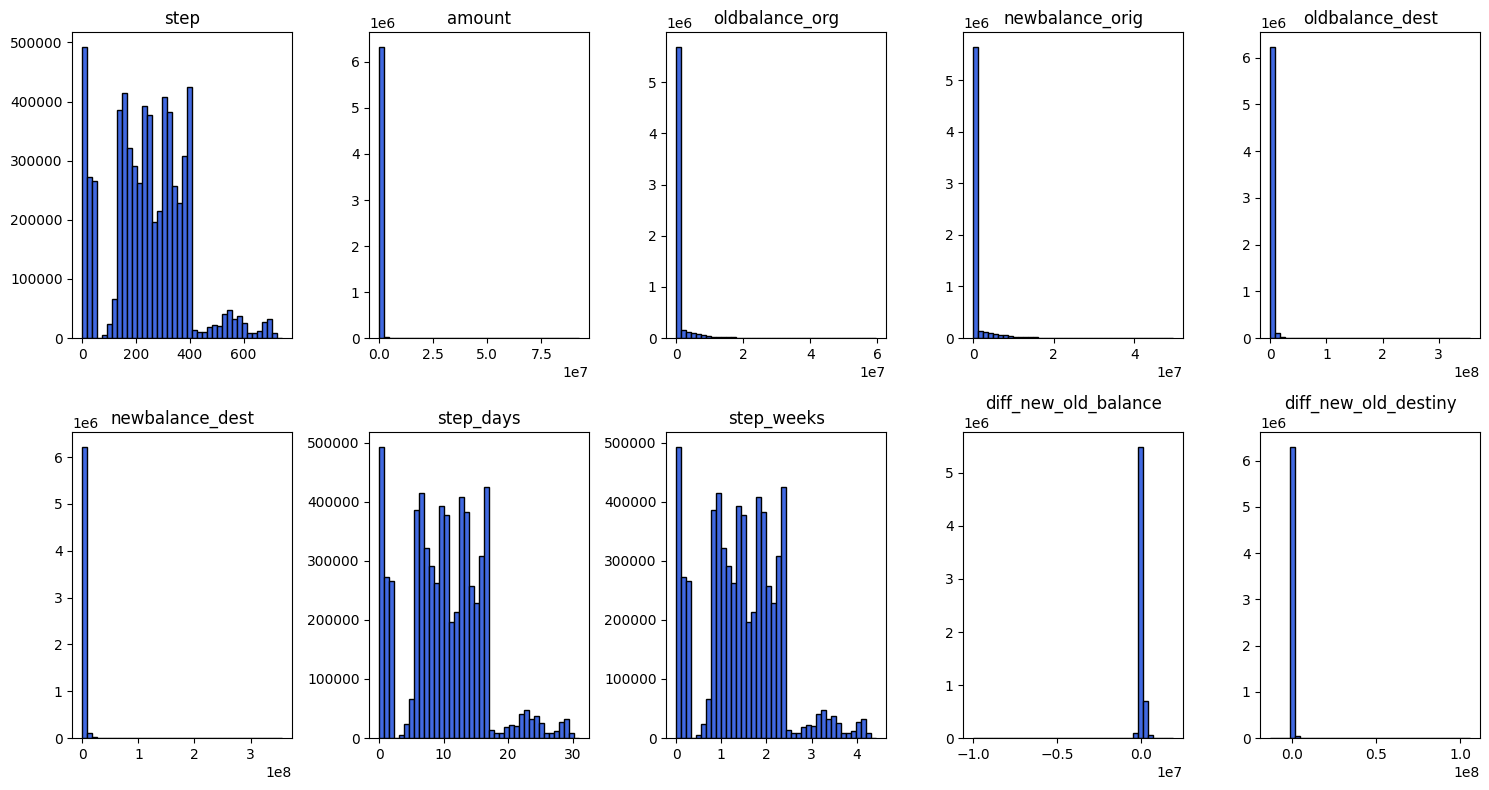

In [16]:
#Distribuição variaveis numéricas
num_attributos = df2.select_dtypes(exclude = 'object')
colunas = num_attributos.columns.tolist()

plt.figure(figsize=(15, 8))
bins = 40
j = 1

for coluna in colunas:
    plt.subplot(2, 5, j)
    plt.hist(num_attributos[coluna], bins=bins, color='royalblue', edgecolor='black')
    plt.title(coluna)
    plt.tight_layout()
    j += 1

plt.show()

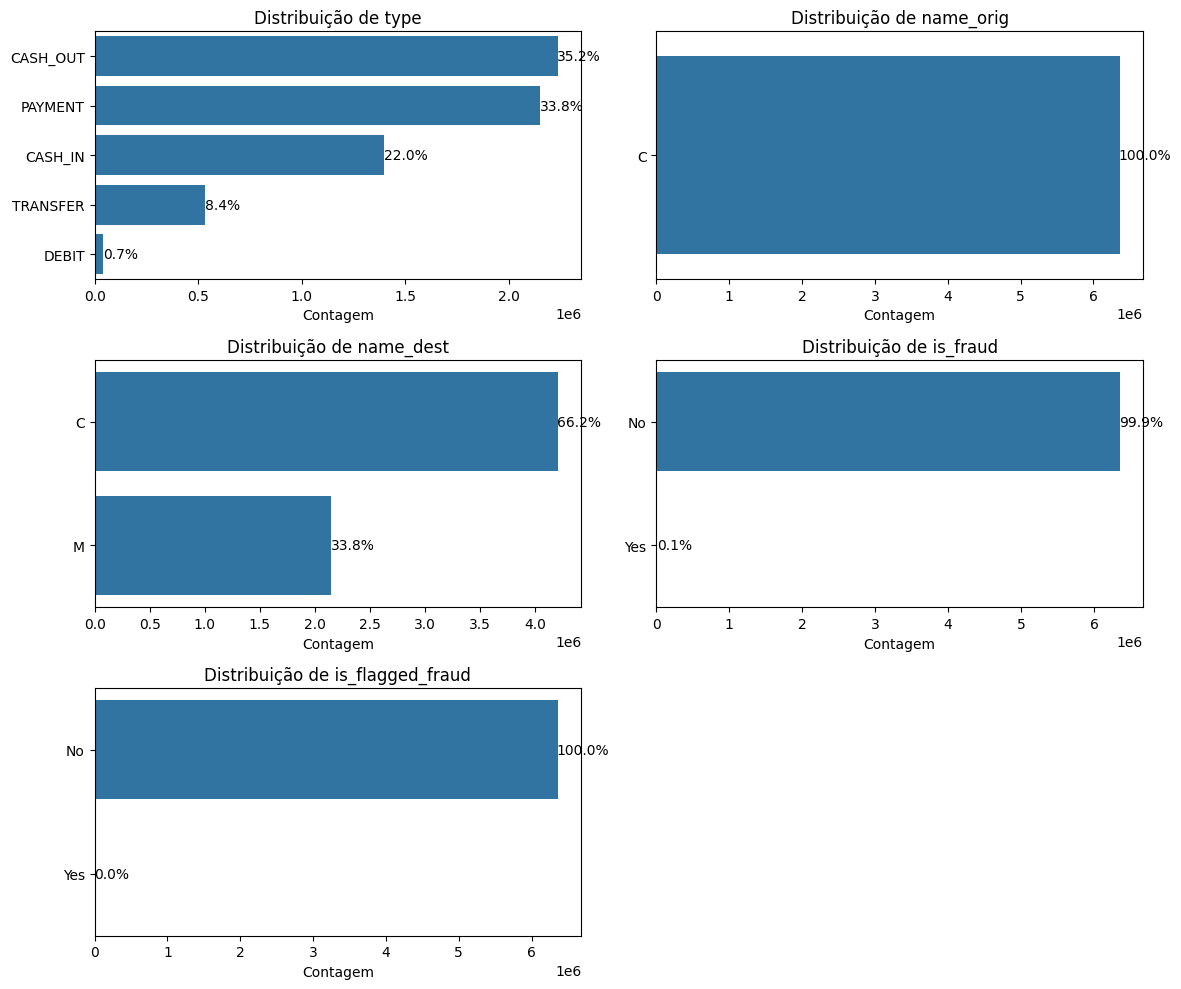

In [17]:
# Distribuição das colunas categóricas


plt.figure(figsize=(12, 10))
cat_attributos = df2.select_dtypes(include='object')
colunas = cat_attributos.columns.tolist()


totais = {column: cat_attributos[column].size for column in colunas}


n_cols = 2
n_rows = (len(colunas) + n_cols - 1) // n_cols

for i, column in enumerate(colunas, 1):
    plt.subplot(n_rows, n_cols, i)


    order = cat_attributos[column].value_counts().index
    ax = sns.countplot(y=column, data=cat_attributos, order=order)


    plt.subplots_adjust(left=0.3, right=0.9, hspace=0.5, wspace=0.3)


    total = totais[column]
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = min(p.get_x() + p.get_width() + 0.02, ax.get_xlim()[1] * 0.95)
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y), va='center')


    plt.title(f'Distribuição de {column}')
    plt.xlabel('Contagem')
    plt.ylabel('')

plt.tight_layout()
plt.show()

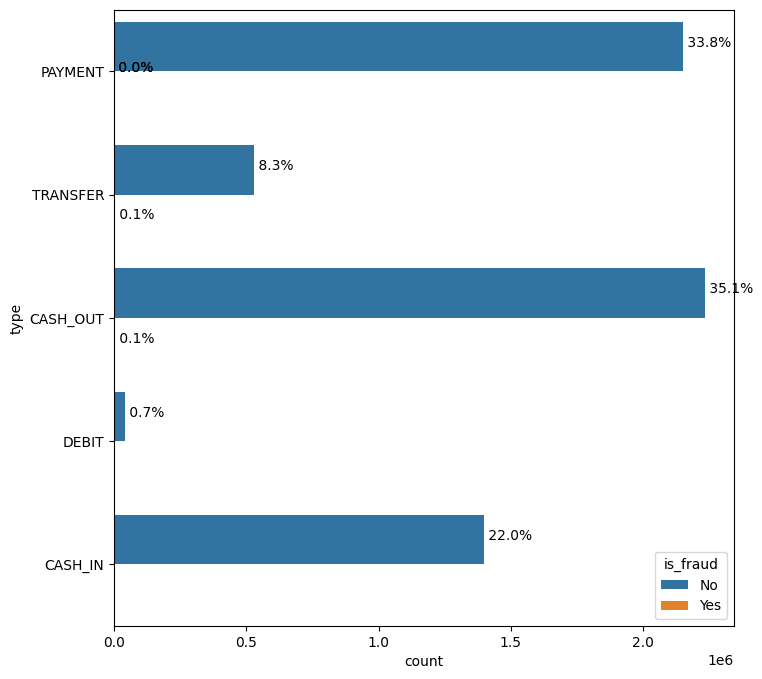

In [18]:
#Analise sobre os tiposde incidencia de fraude

plt.figure(figsize=(8, 8))
ax = sns.countplot(y='type', hue='is_fraud', data=df2)

total = df2['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

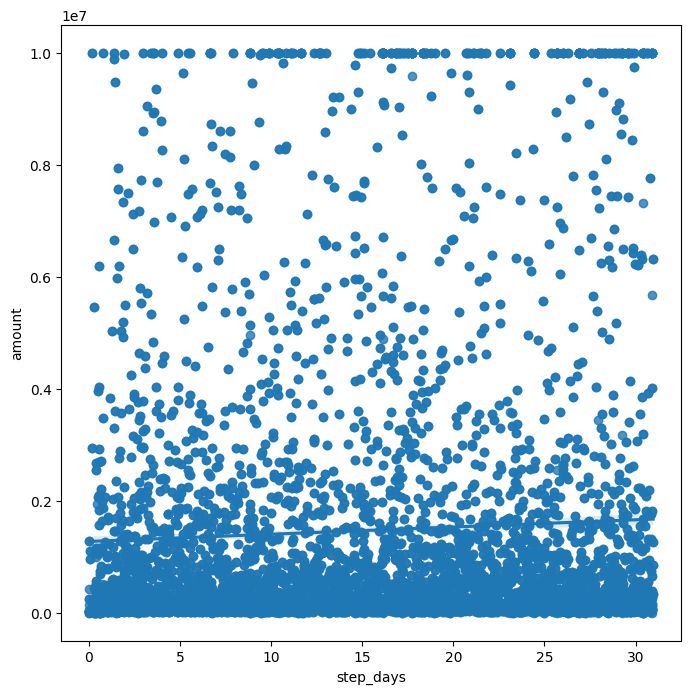

In [19]:
# Verificação para analisar se transações e dias em fraude  são semelhantes.
plt.figure(figsize=(8, 8))
aux1 = df2[df2['is_fraud'] == 'Yes']
sns.regplot(x='step_days', y='amount', data=aux1);

Os valores para transações e dias em fraude não são semelhantes.

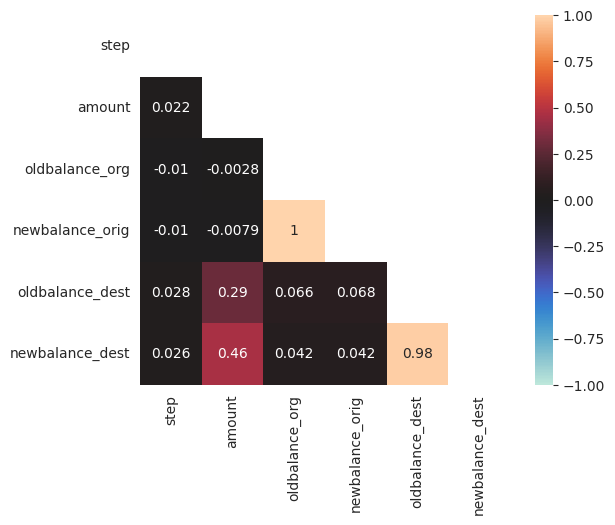

In [20]:
#Correlação entre as váriaveis numericas:

corr = numericas.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=-1, center=0, vmax=1, square=True)

ANÁLISE DE CORRELAÇÃO ENTRE VARIÁVEIS NUMÉRICAS

A matriz de correlação revela:
   Forte correlação positiva (0.98) entre:
   newbalance_dest e oldbalance_dest (esperado, pois representam saldos consecutivos)

Correlações moderadas positivas:
   amount com oldbalance_dest (0.29) e newbalance_dest (0.46)
   step com amount (0.022 - muito fraca)

Correlações negativas insignificantes:
   Variáveis de origem (old/newbalance_orig) mostram correlação próxima de zero

<h2>Pré-processamento dos Dados para Treinamento de Modelos de Machine Learni </h2>

In [21]:
df3 = df2.copy()
X = df3.drop(columns=['is_fraud', 'is_flagged_fraud', 'name_orig', 'name_dest',
                      'step_weeks', 'step_days'], axis=1)
df3['is_fraud'] = df3['is_fraud'].replace( { 'Yes' : 1 , 'No' : 0  } )
y = df3['is_fraud']

<ipython-input-21-9c9a3df838c1>:4: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [22]:
X.shape, y.shape

((6362620, 9), (6362620,))

In [23]:
#Dividindo os dados em treinamento e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.25, stratify=y)

In [24]:
# Transformando a variavel categórica em numerica
coluna_categorica = ['type']
if 'type' in x_treino.columns and 'type' in x_teste.columns:
    x_treino = pd.get_dummies(x_treino, columns=coluna_categorica, drop_first=False)
    x_teste = pd.get_dummies(x_teste, columns=coluna_categorica, drop_first=False)


    x_treino, x_teste = x_treino.align(x_teste, join='left', axis=1, fill_value=0)


x_treino = x_treino.astype(int)
x_teste = x_teste.astype(int)


In [25]:
# Redimensionando as variáveis numéricas para garantir que todas estejam na mesma escala.

colunas_numericas = ['amount', 'oldbalance_org', 'newbalance_orig', 'oldbalance_dest', 'newbalance_dest',
               'diff_new_old_balance', 'diff_new_old_destiny']
mm = MinMaxScaler()
x_treino[colunas_numericas] = mm.fit_transform(x_treino[colunas_numericas])
x_teste[colunas_numericas] = mm.transform(x_teste[colunas_numericas])


In [26]:
#Filtrando os variaveis para selecionar as mais importantes

# Como o conjunto de dados é muito grande, selecionei apenas 10% para o treino,
# com o objetivo de reduzir o tempo de execução e acelerar os testes durante o desenvolvimento.
X_amostra, _, y_amostra, _ = train_test_split(
    x_treino, y_treino, train_size=0.1, stratify=y_treino, random_state=42
)


rf = RandomForestClassifier(n_estimators=30, n_jobs=-1, random_state=42)
rf.fit(X_amostra, y_amostra)

# Pegando a importância das features
importancias = pd.Series(rf.feature_importances_, index=x_treino.columns)
importancias = importancias.sort_values(ascending=False)

importancias

,0
diff_new_old_balance,0.323438
newbalance_dest,0.169053
diff_new_old_destiny,0.146096
amount,0.084711
oldbalance_org,0.079423
step,0.077451
oldbalance_dest,0.059245
type_TRANSFER,0.018922
type_CASH_OUT,0.017405
newbalance_orig,0.017155


In [27]:
colunas_selecionadas = [    'diff_new_old_balance'
	,'newbalance_dest'
	,'diff_new_old_destiny'
	,'oldbalance_org'
	,'step'
	,'amount'
	,'oldbalance_dest'
	,'type_TRANSFER'
	,'newbalance_orig']

In [28]:
x_treino_cs = x_treino[colunas_selecionadas]
x_teste_cs = x_teste[colunas_selecionadas]



In [29]:
#Criando função para avaliação do modelo

def avaliar_modelo(nome_modelo, y_teste, y_pred):
    """
    Calcula e retorna as principais métricas de avaliação para um modelo de classificação.

    Parâmetros:
    nome_modelo: str - Nome do modelo para ser exibido nos resultados.
    y_teste: array-like - Verdadeiros valores da variável alvo.
    y_pred: array-like - Valores previstos pelo modelo.

    Retorna:
    pd.DataFrame: DataFrame contendo as métricas de avaliação.
    """
    # Cálculo das métricas de avaliação
    acuracia_balanceada = balanced_accuracy_score(y_teste, y_pred)
    precisao = precision_score(y_teste, y_pred)
    revocacao = recall_score(y_teste, y_pred)
    f1 = f1_score(y_teste, y_pred)
    kappa = cohen_kappa_score(y_teste, y_pred)

    # Criando um DataFrame com as métricas e arredondando para 3 casas decimais
    resultados = pd.DataFrame({
        'Acurácia Balanceada': np.round(acuracia_balanceada, 3),
        'Precisão': np.round(precisao, 3),
        'Revocação': np.round(revocacao, 3),
        'F1': np.round(f1, 3),
        'Kappa': np.round(kappa, 3)
    }, index=[nome_modelo])

    return resultados

<h3>Regressão Logistica</h3>

In [30]:
#Aplicando os dados ao modelo de regressão logistica

rg = LogisticRegression()
rg.fit(x_treino_cs, y_treino)

y_pred = rg.predict(x_teste_cs)



In [31]:
rg_resultados = avaliar_modelo('Regressão Logistica', y_teste, y_pred)
rg_resultados

,Acurácia Balanceada,Precisão,Revocação,F1,Kappa
Regressão Logistica,0.507,1.0,0.013,0.026,0.026


In [32]:
print(classification_report(y_teste, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       1.00      0.01      0.03      2053

    accuracy                           1.00   1590655
   macro avg       1.00      0.51      0.51   1590655
weighted avg       1.00      1.00      1.00   1590655



<h3>K Nearest Neighbors</h3>

In [33]:
knn = KNeighborsClassifier()
knn.fit(x_treino_cs, y_treino)

y_pred = knn.predict(x_teste_cs)

In [34]:
knn_resultados = avaliar_modelo('K Nearest Neighbors', y_teste, y_pred)
knn_resultados

,Acurácia Balanceada,Precisão,Revocação,F1,Kappa
K Nearest Neighbors,0.751,0.977,0.502,0.663,0.663


In [35]:
print(classification_report(y_teste, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       0.98      0.50      0.66      2053

    accuracy                           1.00   1590655
   macro avg       0.99      0.75      0.83   1590655
weighted avg       1.00      1.00      1.00   1590655



<h3>Support Vector Machine</h3>

In [36]:
svm = SVC( C=1, kernel='rbf', gamma='scale', class_weight='balanced', shrinking=True, cache_size=500, probability=False,max_iter=1000 )
svm.fit(x_treino_cs, y_treino)

y_pred = svm.predict(x_teste_cs)

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



In [37]:
svm_resultados = avaliar_modelo('Support Vector Machines', y_teste, y_pred)
svm_resultados

,Acurácia Balanceada,Precisão,Revocação,F1,Kappa
Support Vector Machines,0.5,0.001,1.0,0.003,0.0


In [38]:
print(classification_report(y_teste, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00   1588602
           1       0.00      1.00      0.00      2053

    accuracy                           0.00   1590655
   macro avg       0.00      0.50      0.00   1590655
weighted avg       0.00      0.00      0.00   1590655



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



<h3>Random Forest</h3>

In [39]:
rf = RandomForestClassifier(n_estimators=30, n_jobs=-1, random_state=42)
rf.fit(x_treino_cs, y_treino)

y_pred = rf.predict(x_teste_cs)

In [40]:
rf_resultados = avaliar_modelo('Random Forest', y_teste, y_pred)
rf_resultados

,Acurácia Balanceada,Precisão,Revocação,F1,Kappa
Random Forest,0.911,0.974,0.822,0.892,0.892


In [41]:
print(classification_report(y_teste, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       0.97      0.82      0.89      2053

    accuracy                           1.00   1590655
   macro avg       0.99      0.91      0.95   1590655
weighted avg       1.00      1.00      1.00   1590655



<h3>XGBoost</h3>

In [42]:
xgb = XGBClassifier()
xgb.fit(x_treino_cs, y_treino)

y_pred = xgb.predict(x_teste_cs)

In [43]:
xgb_resultados = avaliar_modelo('XGBoost', y_teste, y_pred)
xgb_resultados

,Acurácia Balanceada,Precisão,Revocação,F1,Kappa
XGBoost,0.929,0.968,0.858,0.909,0.909


In [44]:
print(classification_report(y_teste, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       0.97      0.86      0.91      2053

    accuracy                           1.00   1590655
   macro avg       0.98      0.93      0.95   1590655
weighted avg       1.00      1.00      1.00   1590655



<h3>LightGBM</h3>

In [45]:
lightgbm = LGBMClassifier()
lightgbm.fit(x_treino_cs, y_treino)

y_pred = lightgbm.predict(x_teste_cs)

[LightGBM] [Info] Number of positive: 6160, number of negative: 4765805
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.949098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2042
[LightGBM] [Info] Number of data points in the train set: 4771965, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001291 -> initscore=-6.651145
[LightGBM] [Info] Start training from score -6.651145


In [46]:
lightgbm_resultados = avaliar_modelo('LightGBM', y_teste, y_pred)
lightgbm_resultados

,Acurácia Balanceada,Precisão,Revocação,F1,Kappa
LightGBM,0.803,0.342,0.608,0.437,0.436


In [47]:
print(classification_report(y_teste, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       0.34      0.61      0.44      2053

    accuracy                           1.00   1590655
   macro avg       0.67      0.80      0.72   1590655
weighted avg       1.00      1.00      1.00   1590655



<h3>Comparação de performance dos modelos</h3>

In [48]:
perfomance_modelos = pd.concat([ rg_resultados, knn_resultados,
                                  rf_resultados, xgb_resultados, lightgbm_resultados,
                                 svm_resultados])
perfomance_modelos.sort_values(by="F1", ascending=True)

,Acurácia Balanceada,Precisão,Revocação,F1,Kappa
Support Vector Machines,0.500,0.001,1.000,0.003,0.000
Regressão Logistica,0.507,1.000,0.013,0.026,0.026
LightGBM,0.803,0.342,0.608,0.437,0.436
K Nearest Neighbors,0.751,0.977,0.502,0.663,0.663
Random Forest,0.911,0.974,0.822,0.892,0.892
XGBoost,0.929,0.968,0.858,0.909,0.909


Após a comparação dos modelos foi constatado que o melhor modelo para se usar é o Xgboosting, então vamos otimizar esse modelo para extrair os melhores resultados

<h3>Fine Tuning de Hiperparâmetros</h3>

In [49]:
f1 = make_scorer(f1_score)

In [50]:
parametros = {
    'booster': ['gbtree', 'gblinear'],
    'eta': [0.3, 0.1, 0.01],
    'scale_pos_weight': [1, 774, 508, 99]
}

In [51]:
gs = GridSearchCV(XGBClassifier(),
                  param_grid= parametros,
                  scoring=f1,
                  cv=StratifiedKFold(n_splits=2))

gs.fit(x_treino_cs, y_treino)

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'booster': ['gbtree', 'gblinear'],
                         'eta': [0.3, 0.1, 0.01],
                         'scale_pos_weight': [1, 774, 508, 99]},
             scoring=make_scorer(f1_score, response_method='predict'))

In [52]:
melhores_parametros = gs.best_params_
melhores_parametros

{'booster': 'gbtree', 'eta': 0.3, 'scale_pos_weight': 1}

In [53]:
gs.best_score_

np.float64(0.8965925480724306)

<h3>Resultados</h3>

In [62]:
xgb_gs = XGBClassifier(
    booster=melhores_parametros['booster'],
    eta=melhores_parametros['eta'],
    gamma= 0.5,
    scale_pos_weight=melhores_parametros['scale_pos_weight']
)

In [63]:
xgb_gs.fit(x_treino_cs, y_treino)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=0.5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [64]:
y_pred = xgb_gs.predict(x_teste_cs)

In [65]:
xgb_gs_resultados = avaliar_modelo('XGBoost GS', y_teste, y_pred)
xgb_gs_resultados

,Acurácia Balanceada,Precisão,Revocação,F1,Kappa
XGBoost GS,0.929,0.969,0.859,0.91,0.91


Antes da otimização, o modelo XGBoost já apresentava resultados sólidos, com um bom equilíbrio entre precisão (0.968), revocação (0.858) e F1-score (0.909). Após o ajuste de hiperparâmetros com GridSearchCV, houve uma melhoria sutil, porém consistente, nas principais métricas: a precisão subiu para 0.969, a revocação para 0.859 e o F1-score para 0.910. A acurácia balanceada e o índice Kappa permaneceram em 0.929 e 0.91, respectivamente.

Esses resultados mostram que o modelo estava bem ajustado desde o início, mas o tuning contribuiu para uma performance ligeiramente mais refinada. Em problemas como detecção de fraude, onde cada detalhe pode impactar na identificação de casos críticos, essas pequenas melhorias são significativas.

<h3>Salvando o modelo </h3>

In [66]:
#Após os resultados, vamos salvar o modelo treinado para um futuro deploy no ambiente de produção.
with open('modelo_xgboost.pkl', 'wb') as f:
    pickle.dump(xgb_gs, f)

Neste projeto, desenvolvi um modelo de machine learning voltado para a detecção de transações fraudulentas em um cenário realista e desbalanceado. Utilizei técnicas de pré-processamento para lidar com o desequilíbrio de classes e explorei algoritmos robustos como o XGBoost, ajustando hiperparâmetros com GridSearchCV para maximizar a métrica F1-score — fundamental em contextos onde há maior penalidade para falsos negativos.

O modelo final apresentou um desempenho consistente, demonstrando boa capacidade de generalização. Durante o processo, pude consolidar conhecimentos em estatística, avaliação de modelos, validação cruzada estratificada, além do uso prático de bibliotecas como pandas, scikit-learn, matplotlib e xgboost.

Mais do que apenas detectar fraudes, esse projeto reforçou a importância de entender os dados, escolher as métricas corretas e buscar o equilíbrio entre sensibilidade e precisão. Foi uma experiência enriquecedora que contribuiu significativamente para minha formação como futuro cientista de dados.
